In [ ]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from tqdm import tqdm
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

f = all_data['e'][2]

def moving_average(a, n=3) :
    ret = np.cumsum(a,0)
    ret[n:] = ret[n:] - ret[:-n]
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

data = np.load("../cnmf_f01555.npz")
cnmf = data['cnmf'].astype(np.float32)
raw = data['raw'].astype(np.float32)
del data
neurons = T.from_numpy(df_f(raw).astype(np.float32)).cuda()
# neurons = T.from_numpy(cnmf).cuda()
neurons_norm = (neurons - neurons.mean(0))/(neurons.std(0)+1e-8)
neurons = neurons_norm

def corrcoef(x):
    # calculate covariance matrix of rows
    mean_x = torch.mean(x, 1, keepdim=True)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # normalize covariance matrix
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c)+1e-8)
    c = c.div(stddev.expand_as(c).t()+1e-8)

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

neuron_corr = corrcoef(neurons)

neuron_linkage = hierarchy.linkage(
    distance.pdist(neuron_corr), method='ward')

neuron_linkage_clusters = hierarchy.fcluster(neuron_linkage,4,criterion='maxclust')
# includes all neurons, even those without cluster
cluster_by_neuron = np.zeros(neurons.shape[0]+1)
for i,v in enumerate(neuron_linkage_clusters):
    cluster_by_neuron[i] = v
cluster_by_neuron = cluster_by_neuron[:-1]

# nclust = int(cluster_by_neuron.max())
# plt.subplots(nclust,1, figsize=[10,5*nclust])
# for clust in range(1,nclust+1):
#     #Select rois in raphe in this slices, and get their coordinates.
#     poly_coords = df[(cluster_by_neuron==clust) & (df.z==z)].poly
#     poly_coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
#     plt.subplot(nclust,1,clust)
#     #Overlay the ROIs on the background image and display:
#     img = vizutil.overlay_coords(back_img, poly_coords, [0,0,1], alpha=.5)
#     plt.imshow(img,interpolation='nearest')
#     plt.title("Cluster {}".format(clust))

dtype = np.float32
# x_fish = F.normalize(neurons,0)
x_fish = neurons
time_fish = T.from_numpy(f.frame_st.mean(1).astype(dtype)).cuda()
if dtype==np.float16:
    u_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
    p_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
else:
    u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
    p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
g_model = T.load("/home/ubuntu/DCM/granger_cnmf_bz=4_3xl1=1e-0&lr=1e-1_15xl1=5e-2&lr=1e-3.pth")
plt.imshow(g_model['G'][0],vmin=-0.1,vmax=0.1)
plt.colorbar()

In [ ]:
class FishSeqData(Dataset):    
    def __init__(self, u, p, x,n_future_steps=1):
        self.x = nn.Parameter(x,requires_grad=False)
        self.p = nn.Parameter(p,requires_grad=False)
        self.u = nn.Parameter(u,requires_grad=False)
        self.nfeatures = x.shape[1]
        self.n_future_steps = n_future_steps
        
    def __len__(self):
        return len(self.x)-self.n_future_steps

    def __getitem__(self, idx):
        indices = slice(idx,idx+self.n_future_steps)
        x_true_indices = slice(idx+1,idx+self.n_future_steps+1)
        return (self.u[indices], self.p[indices],
                self.x[indices], self.x[x_true_indices])
    
# def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6),
#           lambdaC=(1e-5, 1e-5), lambdaD=(1e-5, 1e-5), lr=0.1, verbose=True):
def train(model,data,nepochs=10, lambda1=1e-5,
      lambda2=1e-5, lr=0.1, verbose=True, optimizer=None):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    if verbose:
        A_loss = F.mse_loss(model.A.data,A_true)
        print("A_loss: {}".format(A_loss))
    cum_mse_loss = 0
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            cum_mse_loss += F.mse_loss(X_pred.float(),X_true.float())
        nfeatures = X_true.shape[2]
        print("mse_loss: {:3E}".format(cum_mse_loss/nfeatures))
        if optimizer==None:
            # optimizer = T.optim.SGD(model.parameters(),lr=lr)
            optimizer = T.optim.Adam(model.parameters(),lr=lr,amsgrad=True)
    
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_mse_loss = 0
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            reg = 0
            for param in model.parameters():
                reg += lambda1 * param.norm(1) + lambda2 * param.norm(2)
#             l_A = lambdaA[0] * model.A.norm(1) + lambdaA[1] * model.A.norm(2)
#             l_B = lambdaB[0] * model.B.norm(1) + lambdaB[1] * model.B.norm(2)
#             l_C = lambdaC[0] * model.C.norm(1) + lambdaC[1] * model.C.norm(2)
#             l_D1 = lambdaD[0] * model.Dense1.norm(1) + lambdaD[1] * model.Dense1.norm(2)
#             l_D2 = lambdaD[0] * model.Dense2.norm(1) + lambdaD[1] * model.Dense2.norm(2)
            mse_loss = F.mse_loss(X_pred,X_true)
#             loss = mse_loss + l_A + l_B + l_C + l_D1 #+ l_D2
            loss = mse_loss + reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_mse_loss += float(mse_loss)
#             del X_pred, U,P,X, X_true, mse_loss, l_A, l_B, loss
#             gc.collect()
#             torch.cuda.empty_cache()

        if verbose:
            A_loss = F.mse_loss(model.A.data,A_true)
            B_loss = F.mse_loss(model.B.data,B_true)
            C_loss = F.mse_loss(model.C.data,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("cum_loss: {:3E}, mse_loss: {:3E}".format(cum_loss,cum_mse_loss/nfeatures))
    
    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))

        
class DynamicsCluster(nn.Module,):
    def __init__(self, nfeatures, neuron_cluster_map, n_future_steps,dtype=T.float32, scale=1,std=0.1):
        """DCM model with dynamics between nclusters = max(neuron_cluster_map) features and dense mapping from
        nfeatures -> nclusters"""
        super(DynamicsCluster, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
        nclusters = int(max(neuron_cluster_map))
        self.nclusters = nclusters
        self.cluster = []
        for i in range(nclusters):
            idx = np.argwhere(neuron_cluster_map==i+1)[:,0]
            self.cluster.append(idx)
        self.Dense1 = nn.Parameter(tensor(nfeatures).normal_(std), requires_grad=True)
        self.Dense2 = nn.Parameter(tensor(nfeatures).normal_(std), requires_grad=True)
        self.A = nn.Parameter(tensor(nclusters,nclusters).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nclusters,nclusters).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nclusters).normal_(std),requires_grad=True)
#         self.P = nn.Parameter(tensor(nfeatures).fill_(0.25),requires_grad=True)
        self.n_future_steps = n_future_steps
        self.tensor = tensor
        self.scale = scale
        self.dtype = dtype

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        # batch x time x feature
        x = self.tensor(x_true.shape[0], 1+x_true.shape[1], x_true.shape[2]).zero_()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            X = T.cuda.FloatTensor(x_true.shape[0],self.nclusters, 1).zero_()
            for i in range(self.nclusters):
                idx = self.cluster[i]
                # broadcast inner product
                X[:,i] = T.matmul(x_true[:,t,None,idx],self.Dense1[idx])
            dxdt = (T.matmul((self.A + p[:,t,None,None]*self.B), X).squeeze()) + u[ :,t,None]*self.C
            for i in range(self.nclusters):
                idx = self.cluster[i]
                x[:,t+1,idx] = dxdt[:,i,None]*self.Dense2[idx] + x[:,t,idx]
#                 x[:,t+1,idx] = F.prelu(dxdt[:,i,None]*self.Dense2[idx] + x[:,t,idx], self.P[idx])
        return x[:,1:]

    def predict(self, u, p, x_init,x_true=None):
        # if given x_true, use ground truth for each timestep
        with T.no_grad():
            x = T.cuda.FloatTensor(1+u.shape[0], x_init.shape[0]).zero_()
            x[0] = x_init
            n_future_steps = u.shape[0]
            for t in range(n_future_steps):
                if type(x_true)!=type(None):
                    X = x_true
                else:
                    X = x
                x[t+1] = self(u[None,[t]], p[None,[t]], X[None,[t]],1)
        return x[1:]
    
ntrain = int(np.floor(len(x_fish)*0.8))

n_future_steps = 16
batch_size = 64

data = FishSeqData(u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain],n_future_steps)
train_data = (u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain])
test_data = (u_fish[ntrain:],p_fish[ntrain:],x_fish[ntrain:])

In [ ]:
model = DynamicsCluster(data.nfeatures,cluster_by_neuron,n_future_steps)
zeroModel = DynamicsCluster(data.nfeatures,cluster_by_neuron,n_future_steps)
zeroModel.A.data.zero_()
zeroModel.B.data.zero_()
zeroModel.C.data.zero_()
zeroModel.Dense1.data.zero_()
# zeroModel.Dense2.data.zero_()
pass

In [ ]:
train(zeroModel,data,0,1e-4,0, lr=1e-2,verbose=False)

In [ ]:
train(model,data,10,1e-6,1e-6, lr=1e-2,verbose=False)

U,P,X = test_data
# U,P,X = train_data
X_pred = model.predict(U,P,X[0],X)
dx_true = X[1:] - X[:-1]
dx_pred = X_pred[:-1] - X[:-1]

ncol, nrow = (5,3)
fig, ax = plt.subplots(nrow, ncol, figsize=(19,10))

# ax.set_ylabel("dx/dt")
# ax.set_xlabel("Time")
# ax.set_title("Training data")

for i in range(nrow):
    for j in range(ncol):
        n = np.random.randint(0,len(x_fish))
        ax[i,j].plot(dx_pred[:,n].cpu().numpy(),color='red', alpha=0.6,linewidth=1, label="Model")
        ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=1, alpha=0.6,label="Truth")
        ax[i,j].set_title("Neuron {}".format(n))
fig

# Dynamics Full rank A

In [4]:
class DynamicsSeq(nn.Module):
    def __init__(self, nfeatures, n_future_steps,dtype=T.float32, scale=1,std=0.1):
        super(DynamicsSeq, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
                
        self.A = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nfeatures).normal_(std),requires_grad=True)
        self.n_future_steps = n_future_steps
        self.tensor = tensor
        self.scale = scale
        self.dtype = dtype

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        x = self.tensor(x_true.shape[0], 1+x_true.shape[1], *x_true.shape[2:]).zero_()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            dxdt = (T.matmul((self.A + p[:,t,None,None]*self.B), x_true[:,t,:,None]).squeeze()) + u[ :,t,None]*self.C
            x[:,t+1] = dxdt + x[:,t]
#             x[:,t+1] = F.tanhshrink(dxdt) + x[:,t]
        return x[:,1:]

    def predict(self, u, p, x_init,x_true=None):
        # if given x_true, use ground truth for each timestep
        with T.no_grad():
            x = T.cuda.FloatTensor(1+u.shape[0], x_init.shape[0]).zero_()
            x[0] = x_init
            n_future_steps = u.shape[0]
            for t in range(n_future_steps):
                if type(x_true)!=type(None):
                    X = x_true
                else:
                    X = x
                x[t+1] = self(u[None,[t]], p[None,[t]], X[None,[t]],1)
        return x[1:]

    
n_future_steps = 1
batch_size = 8

data = FishSeqData(u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain],n_future_steps)
model = DynamicsSeq(data.nfeatures,n_future_steps, std=0.01)
model.A.data = g_model["G"]
del g_model

zeroModel = DynamicsSeq(data.nfeatures,n_future_steps)
zeroModel.A.data.zero_()
zeroModel.B.data.zero_()
zeroModel.C.data.zero_()
train(zeroModel,data,0,1e-6,1e-6, lr=1e-3,verbose=False)

In [5]:
train(model,data,2,1e-3,1e-5, lr=1e-2,verbose=False)

  0%|          | 0/283 [00:00<?, ?it/s]Exception KeyError: KeyError(<weakref at 0x7fb7e86ecd60; to 'tqdm' at 0x7fb7fc05df50>,) in <bound method tqdm.__del__ of   0%|          | 0/283 [00:00<?, ?it/s]> ignored


RuntimeError: The size of tensor a (5855) must match the size of tensor b (15888) at non-singleton dimension 2

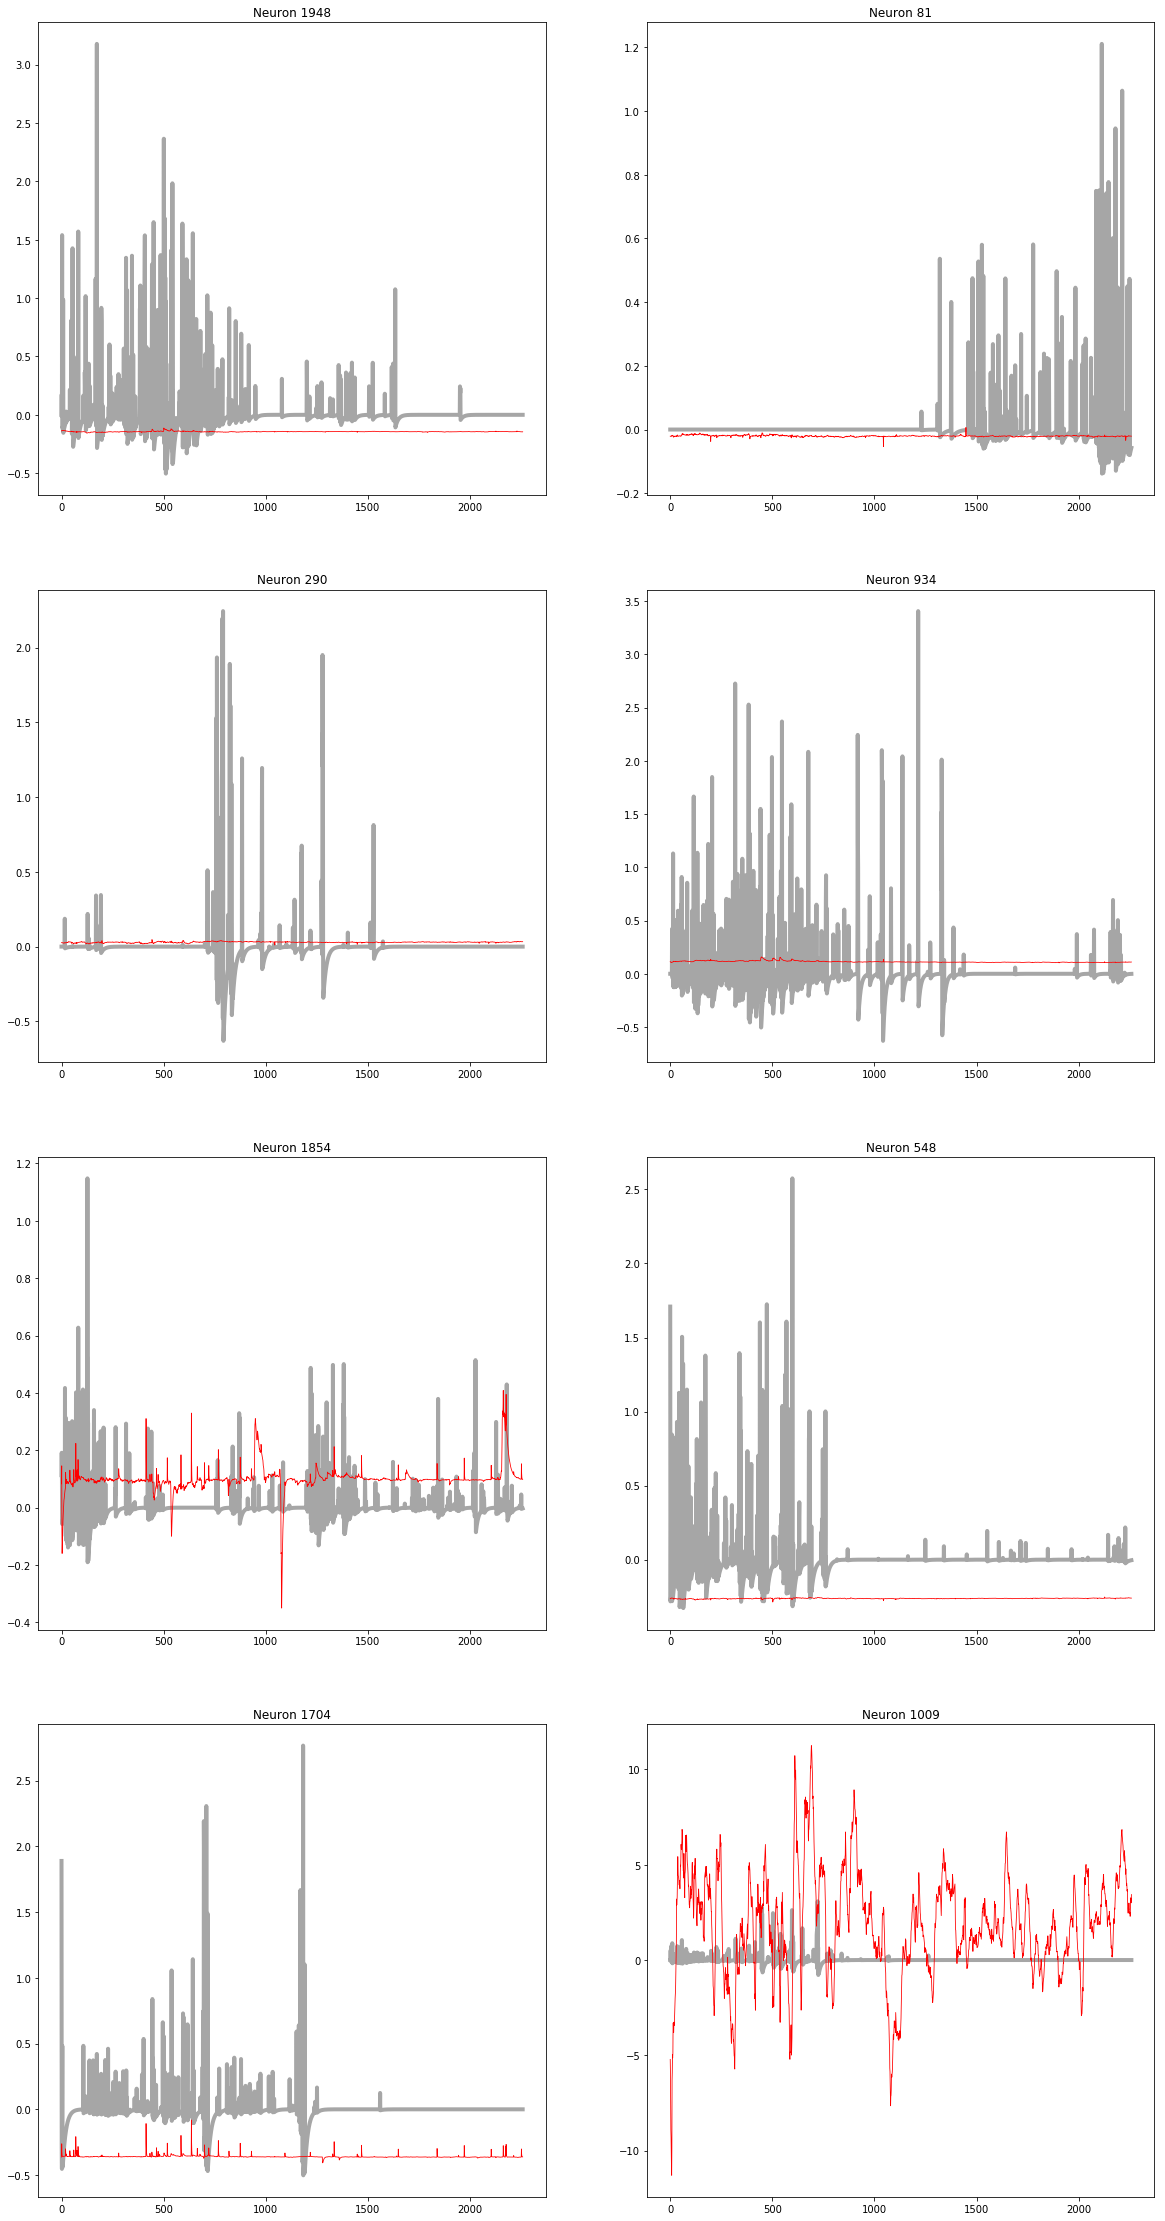

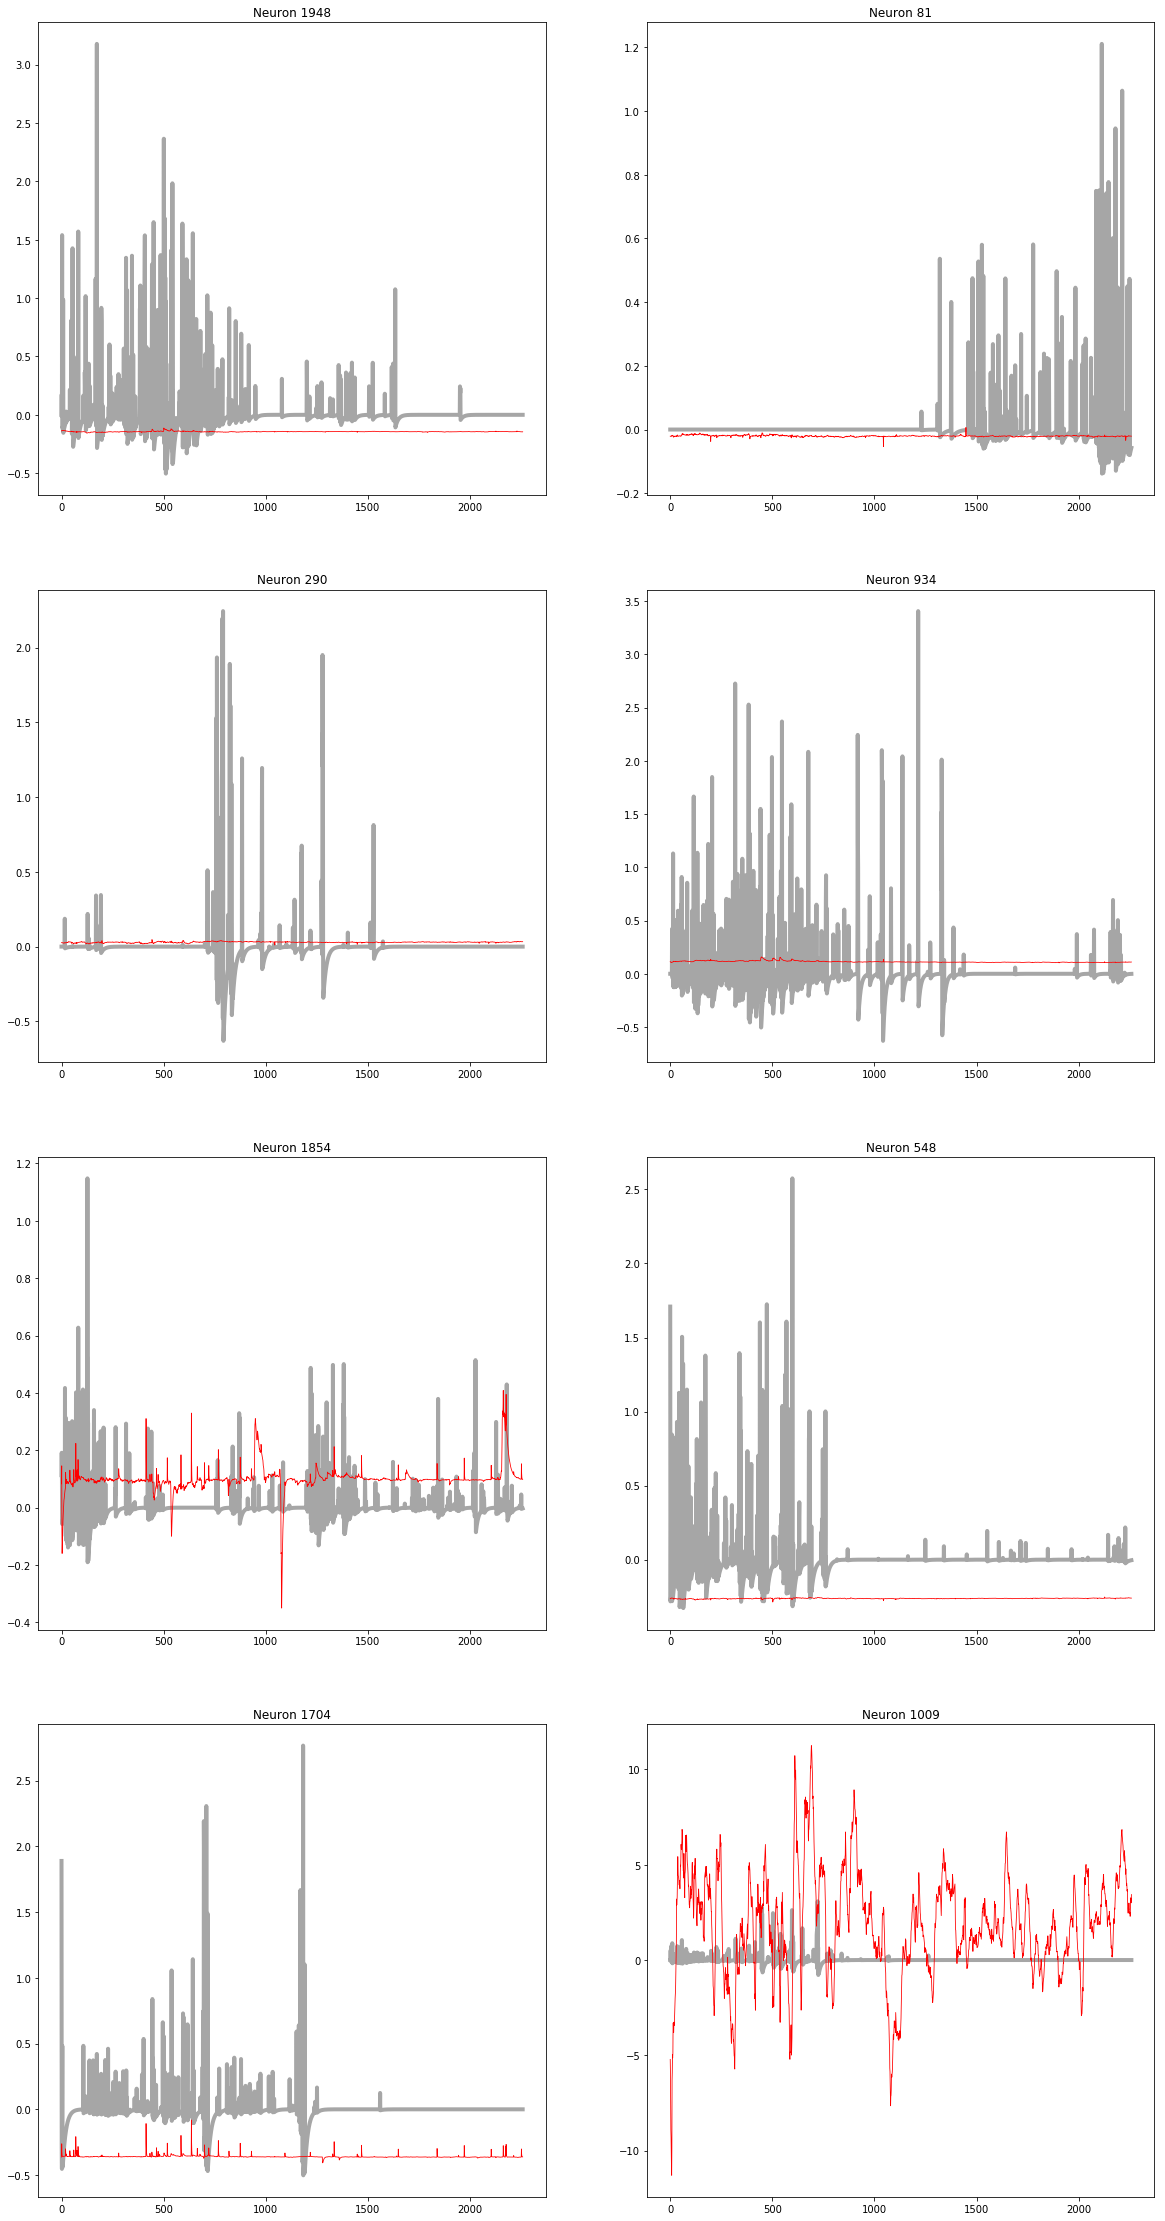

In [7]:
# U,P,X = test_data
U,P,X = train_data
X_pred = model.predict(U,P,X[0],X)
dx_true = X[1:] - X[:-1]
dx_pred = X_pred[:-1] - X[:-1]

ncol, nrow = (2,4)
plt.close('all')
fig, ax = plt.subplots(nrow, ncol, figsize=(20,40))

# ax.set_ylabel("dx/dt")
# ax.set_xlabel("Time")
# ax.set_title("Training data")

for i in range(nrow):
    for j in range(ncol):
        n = np.random.randint(0,len(x_fish))
#         ax[i,j].plot(dx_pred[:,n].cpu().numpy(),color='red', alpha=0.6,linewidth=1, label="Model")
#         ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=1, alpha=0.6,label="Truth")
        ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=4, alpha=0.7,label="Truth")
        ax[i,j].plot(dx_pred[:,n].cpu().numpy(),color='red', alpha=1,linewidth=0.8, label="Model")
        ax[i,j].set_title("Neuron {}".format(n))
fig